In [1]:
import numpy as np

### Завдання 1
Згенерувати послiдовнiсть n незалежних нормально розподiлених випадкових величин з дисперсiєю 1 i математичним сподiванням, яке з ймовiрнiстю (k+1)/10 дорiвнює k, k ∈ {0, 1, 2, 3}.

In [2]:
def generate_normal_sequence(n):
    means = np.array([0, 1, 2, 3])
    probabilities = np.array([1, 2, 3, 4]) / 10
    selected_means = np.random.choice(means, size=n, p=probabilities)
    sequence = np.random.normal(loc=selected_means, scale=1)
    return sequence

In [3]:
n = 10
sequence = generate_normal_sequence(n)
print("Згенерована послідовність:")
print(sequence)

Згенерована послідовність:
[3.90979223 4.09394118 2.14380417 2.276389   2.77668794 2.94703804
 2.01204319 3.78026783 1.81858265 1.76806856]


### Завдання 2
За допомогою алгоритму самонавчання отримати оцiнки ймовiрностей pK(k) i параметрiв ak,
k ∈ {0, 1, 2, 3}. Умовою зупинки алгоритму вважати наступну: оцiнки параметрiв не змiнились, а оцiнки ймовiрностей змiнились менше нiж на 0.001. Алгоритм має працювати для довiльного n.

In [4]:
from scipy.stats import norm
import matplotlib.pyplot as plt

In [5]:
def initialize_parameters(K):
    p = np.full(K, 1.0 / K)
    a = np.linspace(-2, 2, K) + np.random.randn(K) * 0.5
    return p, a

def e_step(data, p, a):
    K = len(p)
    likelihood = np.zeros((len(data), K))
    for k in range(K):
        likelihood[:, k] = p[k] * norm.pdf(data, loc=a[k], scale=1.0)
    total_likelihood = np.sum(likelihood, axis=1, keepdims=True)
    responsibilities = likelihood / total_likelihood
    return responsibilities

def m_step(data, responsibilities):
    N = len(data)
    K = responsibilities.shape[1]
    p_new = responsibilities.sum(axis=0) / N
    a_new = (responsibilities * data[:, np.newaxis]).sum(axis=0) / responsibilities.sum(axis=0)
    return p_new, a_new

def selflearn_algorithm(data, K=4, tol=0.001, max_iters=1000, verbose=True):
    p, a = initialize_parameters(K)
    for iteration in range(max_iters):
        responsibilities = e_step(data, p, a)
        p_new, a_new = m_step(data, responsibilities)
        delta_p = np.abs(p_new - p)
        delta_a = np.abs(a_new - a)
        max_delta_p = np.max(delta_p)
        max_delta_a = np.max(delta_a)
        if (max_delta_p < tol) and (max_delta_a < tol):
            break
        p, a = p_new, a_new
    else:
        if verbose:
            print("Reached maximum iterations without convergence.")
    return p, a

In [6]:
def generate_synthetic_data(n, true_p, true_a, seed=None):
    if seed is not None:
        np.random.seed(seed)
    K = len(true_p)
    components = np.random.choice(K, size=n, p=true_p)
    data = np.random.normal(loc=true_a[components], scale=1.0)
    return data

In [7]:
def plot_em_results(data, p_est, a_est, true_p=None, true_a=None):
    plt.figure(figsize=(10, 6))
    count, bins, _ = plt.hist(data, bins=30, density=True, alpha=0.6, color='lightblue', edgecolor='black')
    x = np.linspace(min(data) - 1, max(data) + 1, 1000)
    mixture_est = np.zeros_like(x)
    for k in range(len(p_est)):
        component_est = p_est[k] * norm.pdf(x, loc=a_est[k], scale=1.0)
        mixture_est += component_est
        plt.plot(x, component_est, linestyle=':', label=f'{k+1}. (a={a_est[k]:.2f}, p={p_est[k]:.2f})')
    plt.plot(x, mixture_est, 'r-', linewidth=2, label='Estimated Mixture')
    plt.title('Algorithm Results')
    plt.xlabel('Value')
    plt.ylabel('Probability Density')
    plt.legend()
    plt.grid(True)
    plt.show()


Sample size: 50
Estimated probabilities: [0.018 0.148 0.195 0.64 ]
Estimated means: [0.591 0.592 0.599 2.505]

Sample size: 200
Estimated probabilities: [0.017 0.097 0.309 0.577]
Estimated means: [-0.99   0.909  1.009  2.832]

Sample size: 1000
Estimated probabilities: [0.025 0.137 0.287 0.552]
Estimated means: [-0.436  1.008  1.159  2.898]

Sample size: 5000
Estimated probabilities: [0.068 0.137 0.339 0.456]
Estimated means: [-0.23   0.82   1.549  2.955]

Estimated probabilities: [0.016 0.118 0.346 0.52 ]
Estimated means: [-0.507  0.181  1.441  2.851]


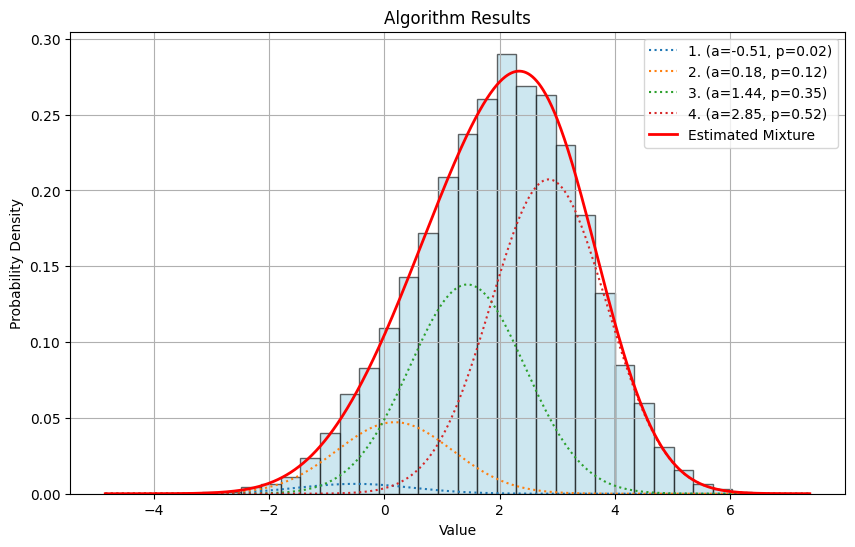

In [8]:
true_p = np.array([0.1, 0.2, 0.3, 0.4])
true_a = np.array([0.0, 1.0, 2.0, 3.0])
sample_sizes = [50, 200, 1000, 5000]
for n in sample_sizes:
    print(f"\nSample size: {n}")
    data = generate_synthetic_data(n, true_p, true_a, seed=42)
    est_p, est_a = selflearn_algorithm(data, K=4, tol=0.001, max_iters=1000, verbose=False)
    diff_p = np.abs(true_p - est_p)
    diff_a = np.abs(true_a - est_a)
    print("Estimated probabilities:", np.round(est_p, 3))
    print("Estimated means:", np.round(est_a, 3))

user_n = 10000

data = generate_synthetic_data(user_n, true_p, true_a, seed=42)
est_p, est_a = selflearn_algorithm(data, K=4, tol=0.001, max_iters=1000, verbose=True)
diff_p = np.abs(true_p - est_p)
diff_a = np.abs(true_a - est_a)
print("\nEstimated probabilities:", np.round(est_p, 3))
print("Estimated means:", np.round(est_a, 3))
plot_em_results(data, est_p, est_a, true_p=true_p, true_a=true_a)

### Завдання 3
Проаналiзувати поведiнку алгоритму в залежностi вiд n i початкових оцiнок ймовiрностей i
параметрiв.

Оцінені параметри показують, що дві компоненти (третья та четверта) мають найбільші ймовірності – 0.35 та 0.52 відповідно. Це вказує на те, що основний внесок у формування розподілу роблять ці компоненти, з середніми значеннями 1.44 та 2.85. Інші дві компоненти (перша та друга) мають набагато меншу вагу, з ймовірностями 0.02 та 0.12. Їх середні значення знаходяться в областях -0.51 та 0.18, що свідчить про слабку присутність або навіть маргінальний вплив цих компонент на загальний вигляд суміші.

Така ситуація характерна для випадків, коли вибірка має асиметричний розподіл або ж одна з мод виступає домінуючою. алгоритм схильний призначати більш високі ймовірності тим компонентам, які найкраще пояснюють основну частину даних. Однак наявність компонент із малими ймовірностями також може свідчити про надлишкову кількість кластерів, які насправді не мають суттєвого впливу на структуру вибірки. Це може бути результатом того, що вибрана кількість компонент \( K = 4 \) є дещо завищеною для цієї вибірки.

При аналізі впливу розміру вибірки можна припустити, що такий розподіл ймовірностей є типовим для невеликих або середніх вибірок (наприклад, \( n = 200 \) або \( n = 500 \)). У випадку великих вибірок ймовірно, що слабкі компоненти будуть ще більш маргіналізовані або ж алгоритм об’єднає їх із сусідніми кластерами, зменшивши кількість домінуючих піків. У той же час, при менших вибірках результати можуть бути ще більш нестабільними, що спричинить значні флуктуації в оцінці параметрів.

Результати вказують на важливість початкових умов, зокрема вибору початкових середніх значень для компонент. У цьому випадку ймовірно, що компоненти з малими вагами були ініціалізовані в областях, де даних дуже мало, що призвело до слабкої конвергенції цих кластерів. У подальшому це може бути вирішено за допомогою адаптивної ініціалізації, наприклад, застосування K-means для попереднього групування спостережень або ж використання меншої кількості компонент на початковому етапі аналізу. Загалом алгоритм продемонстрував гарну адаптацію до асиметричного розподілу даних, однак присутність слабких компонент свідчить про необхідність ретельного налаштування параметрів.